# Автоматическая разметка данных

Ноутбук предназначен для автоматической разметки данных для решения задачи детектирования объектов. Для детектирования используется нейронная сеть [Grounding DINO](https://arxiv.org/pdf/2303.05499.pdf?ref=blog.roboflow.com). Вдохновением для создания ноутбука послужила статья [Grounding DINO:SOTA Zero-Shot Object Detection](https://blog.roboflow.com/grounding-dino-zero-shot-object-detection/) и [туториал](https://github.com/roboflow/notebooks/blob/main/notebooks/zero-shot-object-detection-with-grounding-dino.ipynb?ref=blog.roboflow.com) в формате jupyter ноутбука.

В данном проекте реализованы: 
1. Запуск Docker контейнера с предустановленными зависимостями; 
2. Установка классов и порогов детектирования;
3. Детектирование объектов;
4. Сохранение разметки в формате YOLO;
5. Создание архива для загрузки разметки в CVAT.

Разметка сохраняется в формате YOLO и упаковывается в архив, который можно загрузить в инструмент разметки данных [CVAT](https://www.cvat.ai/).

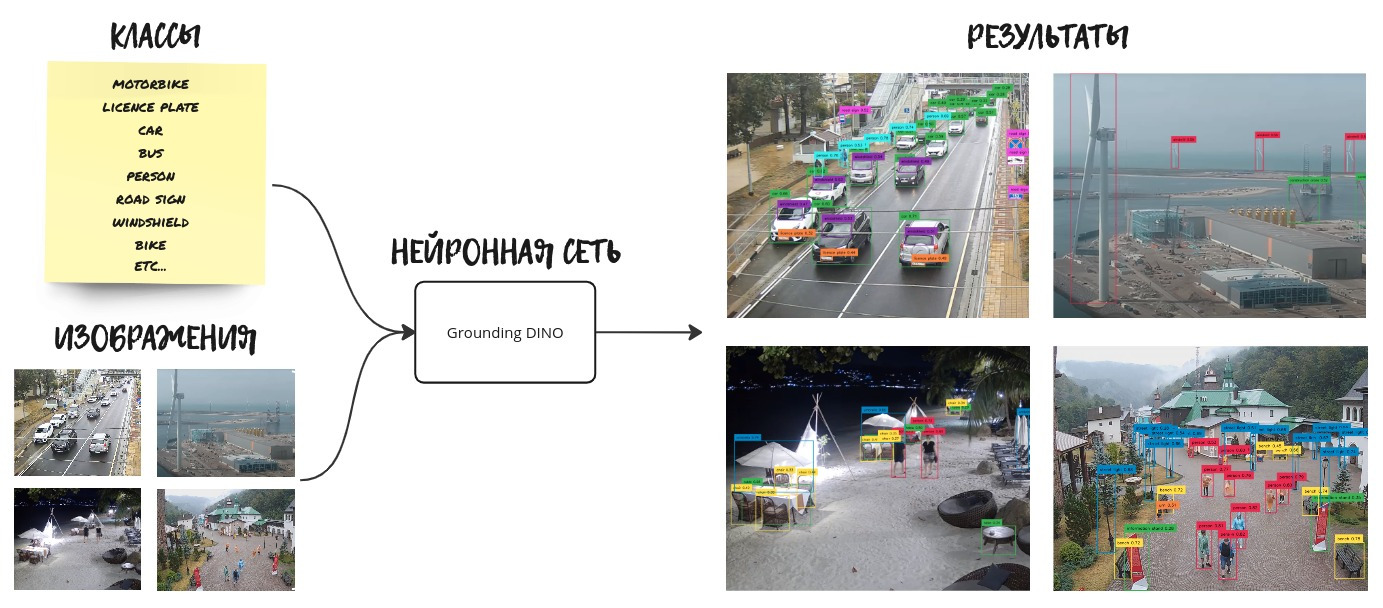

---

### Сборка необходимых библиотек
В это время вы можете сделать перерыв на кофе, так как этот процесс может занять некоторое время.

In [1]:
%cd /root/GroundingDINO
!python3 setup.py install develop > null

/root/GroundingDINO
/root/.local/lib/python3.8/site-packages/torch/utils/cpp_extension.py:388: UserWarning: The detected CUDA version (11.4) has a minor version mismatch with the version that was used to compile PyTorch (11.7). Most likely this shouldn't be a problem.
  warnings.warn(CUDA_MISMATCH_WARN.format(cuda_str_version, torch.version.cuda))
Emitting ninja build file /root/GroundingDINO/build/temp.linux-x86_64-3.8/build.ninja...
Compiling objects...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
zip_safe flag not set; analyzing archive contents...
groundingdino.__pycache__._C.cpython-38: module references __file__
groundingdino.util.__pycache__.misc.cpython-38: module references __file__
TEST FAILED: build/bdist.linux-x86_64/egg does NOT support .pth files
bad install directory or PYTHONPATH

You are attempting to install a package to a directory that is not
on PYTHONPATH and which Python does not read ".pth" file

In [2]:
import os
import sys

import cv2
import shutil
import supervision as sv

sys.path.append('/app/')
from src.worker import process

## Настройки

In [3]:
# Директория с изображениями для разметки
SOURCE_IMAGE_PATH = '/app/data/example/'

# Директория для сохранения набора данных
SOURCE_DIRECTORY_PATH = '/app/data/dataset_example/'

# Описание классов
CLASSES = {'motorbike': 0.40,
           'car': 0.25,
           'bus': 0.25,
           'truck': 0.25,
           'licence plate': 0.30,
           'windshield': 0.45,
           'person': 0.50,
           'road sign': 0.40,
           'bike': 0.40 
          }

# Конфигурационный файл для модели
CONFIG_PATH = "/root/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"

# Веса модели
WEIGHTS_PATH = "/root/weights/groundingdino_swint_ogc.pth"

# Установка порогов для GroundingDINO
BOX_TRESHOLD = 0.20
TEXT_TRESHOLD = 0.15

# Параметры для отображения
SAMPLE_SIZE = 9
SAMPLE_GRID_SIZE = (3, 3)
SAMPLE_PLOT_SIZE = (16, 16)

## Загрузка модели

Проверка, что необходимые файлы загружены

In [4]:
if not os.path.isfile(CONFIG_PATH):
    print("Конфигурационный файл отсутствует.")
if not os.path.isfile(WEIGHTS_PATH):
    print("Файл с весами модели отсутствует.")

In [5]:
from groundingdino.util.inference import Model

model = Model(model_config_path=CONFIG_PATH, model_checkpoint_path=WEIGHTS_PATH)

/root/.local/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


### Получаем список изображений

In [6]:
image_paths = sv.list_files_with_extensions(
    directory=SOURCE_IMAGE_PATH,
    extensions=["png", "jpg", "jpg", "jpeg"])

image_paths = list(set(image_paths))

print('Общее количество изображений:', len(image_paths))

Общее количество изображений: 9


Выполняем отрисовку нескольких изображений из набора данных

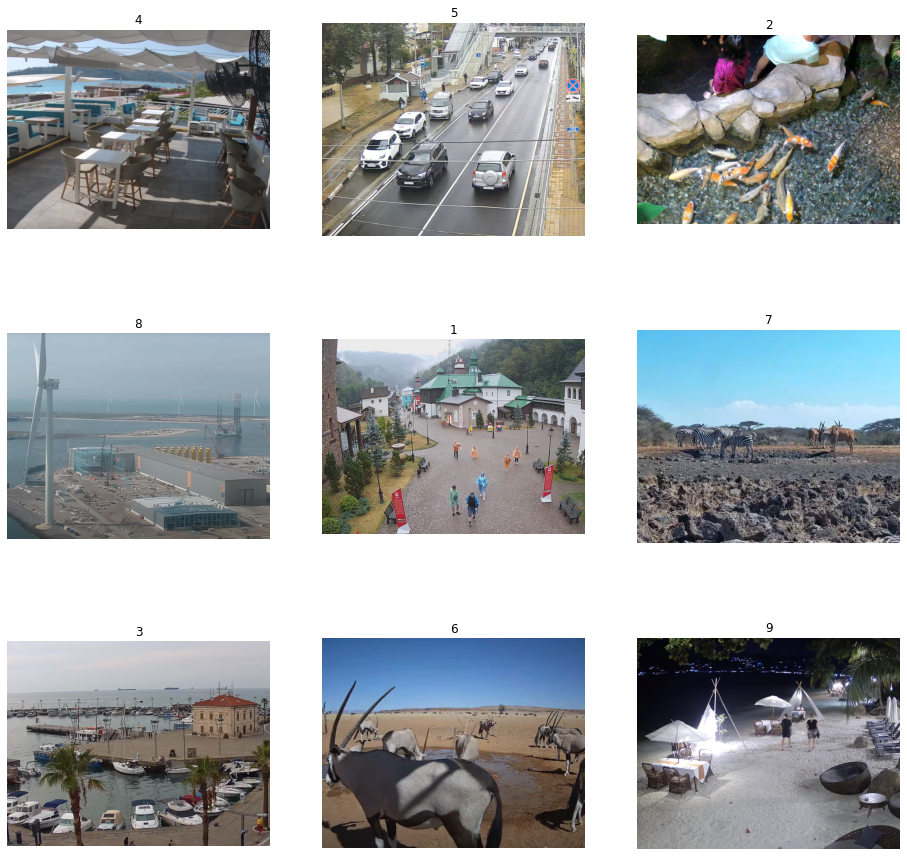

In [7]:
titles = [
    image_path.stem
    for image_path
    in image_paths[:SAMPLE_SIZE]]
images = [
    cv2.imread(str(image_path))
    for image_path
    in image_paths[:SAMPLE_SIZE]]

sv.plot_images_grid(images=images, titles=titles, grid_size=SAMPLE_GRID_SIZE, size=SAMPLE_PLOT_SIZE)

## Запускаем обработку изображений нейронной сетью

In [8]:
detections = process(image_paths, CLASSES, model, BOX_TRESHOLD, TEXT_TRESHOLD, SOURCE_DIRECTORY_PATH)

  0%|          | 0/9 [00:00<?, ?it/s]/root/.local/lib/python3.8/site-packages/transformers/modeling_utils.py:900: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/root/.local/lib/python3.8/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 9/9 [00:32<00:00,  3.58s/it]


## Отрисовка детекций

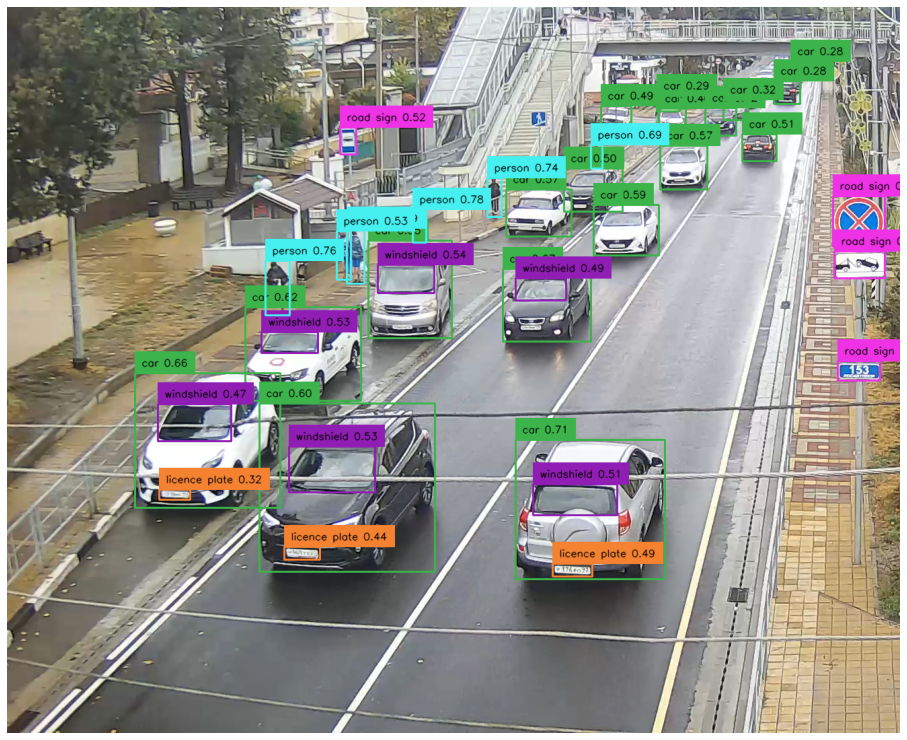

In [9]:
img_idx = 1

image = cv2.imread(str(image_paths[img_idx]))

box_annotator = sv.BoxAnnotator()

labels = [
    f"{list(CLASSES.keys())[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _
    in detections[img_idx]]

annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections[img_idx], labels=labels)


%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

## Создание архива для загрузки в CVAT

Создание файла train.txt

In [10]:
with open(SOURCE_DIRECTORY_PATH + "train.txt", "w") as f:
    for path in image_paths:
        yolo_img_path = str(path).replace(SOURCE_IMAGE_PATH, 'obj_train_data/')
        f.write(yolo_img_path + "\n")

Создание файла obj.names

In [11]:
with open(SOURCE_DIRECTORY_PATH + "obj.names", "w") as f:
    for class_name in CLASSES.keys():
        f.write(class_name + "\n")

Создание файла obj.data

In [12]:
with open(SOURCE_DIRECTORY_PATH + "obj.data", "w") as f:
    data = f'classes = {len(CLASSES)}\n'\
            'train = train.txt\n'\
            'names = obj.names\n'\
            'backup = backup/'
    f.write(data)

Создание ZIP архива

In [13]:
shutil.make_archive(SOURCE_DIRECTORY_PATH, 'zip', SOURCE_DIRECTORY_PATH)

'/app/data/dataset_example.zip'